In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler

import os, time
import argparse

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Preprocess

## Loading dataset  
Pytorch tutorial for CIFAR-10: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html  
Collection of high acc NN for CIFAR-10 https://github.com/kuangliu/pytorch-cifar

In [0]:
from torchvision import datasets
train_data = datasets.CIFAR10('./cifar10_data', train=True, download=True)
# use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
print(x.shape)
train_mean = np.mean(x, axis=(0, 1))
train_std = np.std(x, axis=(0, 1))
print(train_mean / 255, train_std / 255)

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [0]:
# this section is to create train and validate set
transform_train = transforms.Compose([                                      
    transforms.ToTensor(),
    # changed to the computed mean/std 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

transform_test = transforms.Compose([                                      
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
num_train = len(trainset)
indices = list(range(num_train))
train_idx, valid_idx = indices[10000:], indices[:10000]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler,
                                           num_workers=2)
validloader = torch.utils.data.DataLoader(
    trainset,batch_size=128, sampler=valid_sampler,
    num_workers=2, 
)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## CNN
http://colah.github.io/posts/2014-07-Conv-Nets-Modular/  
Docs for `torch.nn`: https://pytorch.org/docs/stable/nn.html#linear  
LeNet 5 : https://ieeexplore.ieee.org/abstract/document/726791  
CIFAR-10 nn plot: https://chahatdeep.github.io/docs/NNvsSVM.pdf

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
  '''Convolutional Neural Network on the 32*32 input grid'''
  def __init__(self,dropout=0,activation='ReLU'):
    super(ConvNet, self).__init__()
    # set the 1st convolutional layer with in_channels=3 out_channels=6 kernel_size=5*5
    self.conv1 = nn.Conv2d(3, 6, 5)
    # set the 2nd convolutional layer within_channels=6 out_channels=16 kernel_size=5*5
    self.conv2 = nn.Conv2d(6, 16, 5)
    # set a max pooling layer to pick up the max value from a selected region
    # height = 2, width = 2
    self.pool = nn.MaxPool2d(2, 2)
    # set 3 layers of fully connected MLP that apply linear transformations to the incoming data
    # input: 16 grids each of which is 5*5, output: 120 units
    self.fc1   = nn.Linear(16*5*5, 120)
    # input: 120 units, output: 84 units
    # 84: represent a stylized image of the corresponding character class drawn on a 7*12 bitmap 
    self.fc2   = nn.Linear(120, 84)
    # set the dropout probability
    self.dropout = nn.Dropout(dropout)
    # transform to the 10 classes as output
    self.fc3   = nn.Linear(84, 10)
    self.activation = activation

  def forward(self, x):
    if self.activation == 'ReLU':
      f = F.relu
    elif self.activation == 'sigmoid':
      f = torch.sigmoid
    elif self.activation == 'tanh':
      f = torch.tanh
    x = self.pool(f(self.conv1(x)))
    x = self.pool(f(self.conv2(x)))     
    x = x.view(-1, 16 * 5 * 5)
    x = f(self.fc1(x))
    x = self.dropout(x)
    x = f(self.fc2(x))
    x = self.fc3(x)
    return x


In [0]:
def train(epoch):
    '''Run one epoch, return the train acc and loss'''
    net.train()   # switch to training mode

    print('\nEpoch: %d' % epoch)  # print the current number of epoch
    # initialize several performance indicators
    train_loss = 0
    batch_idx = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)   # put the training pairs to gpu if applies
        optimizer.zero_grad()   # clear the current gradient, otherwise it will accumulate
        outputs = net(inputs)   # compute the outputs
        loss = criterion(outputs, targets)    # calculate the loss function based on the criterion defined outside of the function
        loss.backward()   # computes dloss/dx for every parameter x 
        optimizer.step()  # update the parameter based on the current gradient

        train_loss += loss.item() # extracts the loss’s value as a Python float
        _, predicted = outputs.max(1) # match the predicted label with the output
        total += targets.size(0)    # counter for the number of instances we've trained
        correct += predicted.eq(targets).sum().item()

    print('Training accuracy : %0.3f %%' % (100 * correct / total))   
    return 100 * correct / total, train_loss/(batch_idx+1)   # return the training acc and training loss per batch

In [0]:

def validate(epoch,lr,best_epoch,dropout=0,activation='ReLU',optimizer='SGD',patience=10,stop=False):
  '''Evaluate the model, return the validating acc, loss, epoch number that has the best acc'''
  global cnn_best_acc_valid   #refer to a global variable
  global epochs_no_improve
  global cnn_min_loss
  global cnn_local_best # the best acc for each net
  net.eval()    # switch to evaluation mode
  test_loss = 0
  batch_idx = 0
  correct = 0
  total = 0
  with torch.no_grad():   # with no_grad() we have higher speeds and can use larger batch size (100)
      for batch_idx, (inputs, targets) in enumerate(validloader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

  print('Validation accuracy : %0.3f %%' % (100 * correct / total))


  # Save the model with the largest test acc
  acc = 100.*correct/total
  if acc > cnn_best_acc_valid:
      print('Saving..')
      state = {
          'net': net.state_dict(),
          'acc': acc,
          'epoch': epoch,
          'lr': lr,
          'dropout': dropout,
          'activation':activation,
          'optimizer': optimizer,
      }
      torch.save(state, 'bestCNN_valid.pth')
      cnn_best_acc_valid = acc
  # if the current acc is larger than this model's best acc, update the epoch which has the best acc
  #if test_loss < cnn_local_best:
  #  best_epoch = epoch
  # Early stopping based on the loss 
  # if the test loss is decreasing in 'patience' consecutive times, return the signal to break
  if test_loss < cnn_min_loss:
    epochs_no_improve = 0
    cnn_min_loss = test_loss
    best_epoch = epoch
  else:
    epochs_no_improve += 1
  if epochs_no_improve == patience:
    print('Early stopping!')
    stop = True
  

  return 100 * correct / total, test_loss/(batch_idx+1), best_epoch, stop #return the test acc for current model

# Training

## Tuning the activation function using validation set
reason that the validation acc is higher at first:https://stackoverflow.com/questions/50422872/validation-and-training-accuracy-high-in-the-first-epoch-keras

In [0]:
net = ConvNet()
# Define a Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
cnn_best_acc_valid = 0
epochs_no_improve = 0
cnn_min_loss = np.Inf
cnn_local_best = np.Inf
def tuningActivation(maxepoch,lr,activations,dropout=0):
  '''
  activation = ['ReLU','sigmoid','tanh']
  optimizer = []
  '''
  colors = ['r', 'b', 'g', 'c', 'b']
  global cnn_min_loss
  global epochs_no_improve
  global cnn_local_best
  for activation,color in zip(activations,colors):
    global net 
    global optimizer
    cnn_min_loss = np.Inf
    epochs_no_improve = 0
    cnn_local_best = 0 # reset the single model's acc to 0 at the start

    net = ConvNet(dropout=dropout,activation = activation)
    net = net.to(device)
    if  device== 'cuda':
      net = torch.nn.DataParallel(net)
      cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    epoch_list = list(range(1,maxepoch+1))
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    valid_acc_list = []
    train_acc_list = [] 
    train_loss_list = []
    valid_loss_list = []
    best_epoch = 0 
    start = time.time()
    for epoch in epoch_list:  # train and validate the model until
      train_acc, train_loss = train(epoch)
      valid_acc, valid_loss, best_epoch, stop = validate(epoch,lr=lr,best_epoch=best_epoch,dropout=dropout,activation=activation)
      valid_acc_list.append(valid_acc)
      train_acc_list.append(train_acc)
      train_loss_list.append(train_loss)
      valid_loss_list.append(valid_loss)
      if stop: # if reach the patience limit, exit the loop
        break

    end = time.time()
    print('Time spent: %0.2f s' % (end-start))
    print('The lowest loss is at epoch '+ str(best_epoch))
    
    # plot results
    plt.plot(epoch_list[:len(train_loss_list)], train_loss_list, '--', color=color, label=activation+" train")
    plt.plot(epoch_list[:len(valid_loss_list)], valid_loss_list, color=color, label=activation+" val")
    plt.plot(best_epoch, min(valid_loss_list), marker='o', color=color,  markersize=5)
    print('Activation: {} - lowest validation loss: {}'.format(activation, min(valid_loss_list)))
    print('-'*100)
  plt.legend()
  plt.title("Loss vs. # of Epochs")
  plt.savefig("cnn_activation.png")
  



Epoch: 1
Training accuracy : 28.190 %
Validation accuracy : 41.880 %
Saving..

Epoch: 2
Training accuracy : 44.958 %
Validation accuracy : 47.040 %
Saving..

Epoch: 3
Training accuracy : 51.440 %
Validation accuracy : 54.200 %
Saving..

Epoch: 4
Training accuracy : 55.892 %
Validation accuracy : 55.870 %
Saving..

Epoch: 5
Training accuracy : 58.718 %
Validation accuracy : 57.760 %
Saving..

Epoch: 6
Training accuracy : 61.615 %
Validation accuracy : 58.540 %
Saving..

Epoch: 7
Training accuracy : 63.807 %
Validation accuracy : 61.860 %
Saving..

Epoch: 8
Training accuracy : 65.730 %
Validation accuracy : 61.460 %

Epoch: 9
Training accuracy : 67.502 %
Validation accuracy : 62.220 %
Saving..

Epoch: 10
Training accuracy : 68.615 %
Validation accuracy : 62.560 %
Saving..

Epoch: 11
Training accuracy : 70.198 %
Validation accuracy : 64.050 %
Saving..

Epoch: 12
Training accuracy : 71.228 %
Validation accuracy : 64.460 %
Saving..

Epoch: 13
Training accuracy : 72.575 %
Validation accurac

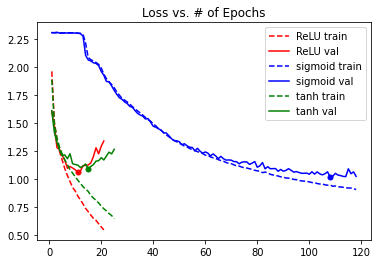

In [0]:
# early stopping after 5 non-decreasing loss in a roll + timer + best epoch marker
activations = ['ReLU','sigmoid','tanh']
tuningActivation(500,0.01,activations=activations)

## Tuning the optimizer type using validation set

In [0]:
net = ConvNet()
# Define a Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
cnn_best_acc_valid = 0
cnn_min_loss = np.Inf
epochs_no_improve = 0
cnn_local_best = 0
def tuningOptimizer(maxepoch,lr,optimizers,dropout=0):
  '''
  activation = ['ReLU','sigmoid','tanh']
  optimizer = []
  '''
  colors = ['r', 'b', 'g', 'c', 'b']
  global cnn_min_loss
  global epochs_no_improve
  global cnn_local_best
  for opt,color in zip(optimizers,colors):
    global net 
    global optimizer
    cnn_min_loss = np.Inf
    epochs_no_improve = 0
    cnn_local_best = 0 # reset the single model's acc to 0 at the start

    net = ConvNet(dropout=dropout,activation = 'ReLU')
    net = net.to(device)
    if  device== 'cuda':
      net = torch.nn.DataParallel(net)
      cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss()
    epoch_list = list(range(1,maxepoch+1))
    if opt=='adagrad':
      optimizer = optim.Adagrad(net.parameters(), lr=lr)
    elif opt=='adam':
      optimizer = optim.Adam(net.parameters(), lr=lr)
    elif opt=='rmsprop':
      optimizer = optim.RMSprop(net.parameters(), lr=lr)
    elif opt=='sgd':
      optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    valid_acc_list = []
    train_acc_list = [] 
    train_loss_list = []
    valid_loss_list = []
    best_epoch = 0 
    start = time.time()
    for epoch in epoch_list:
      train_acc, train_loss = train(epoch)
      valid_acc, valid_loss, best_epoch, stop = validate(epoch,lr=lr,best_epoch=best_epoch,dropout=dropout,optimizer=opt)
      valid_acc_list.append(valid_acc)
      train_acc_list.append(train_acc)
      train_loss_list.append(train_loss)
      valid_loss_list.append(valid_loss)
      if stop: # if reach the patience limit, exit the loop
        break
    end = time.time()
    print('Time spent: %0.2f s' % (end-start)) # print the time spent for this model(train+validate)
    print('The lowest loss is at epoch '+ str(best_epoch))

    # plot train loss vs epoch
    plt.plot(epoch_list[:len(train_loss_list)], train_loss_list, '--', color=color, label=opt+" train")
    # plot validation loss vs epoch
    plt.plot(epoch_list[:len(valid_loss_list)], valid_loss_list, color=color, label=opt+" val")
    # plot the point which has the lowest loss among all the epochs
    plt.plot(best_epoch, min(valid_loss_list), marker='o', color=color,  markersize=5)
    print('Activation: {} - lowest validation loss: {}'.format(opt, min(valid_loss_list)))
    print('-'*100)
  plt.legend()
  plt.title("Loss vs. Optimizer types")
  plt.savefig("cnn_optimizer.png")



Epoch: 1
Training accuracy : 38.510 %
Validation accuracy : 46.780 %
Saving..

Epoch: 2
Training accuracy : 48.733 %
Validation accuracy : 50.370 %
Saving..

Epoch: 3
Training accuracy : 51.837 %
Validation accuracy : 51.660 %
Saving..

Epoch: 4
Training accuracy : 54.258 %
Validation accuracy : 54.180 %
Saving..

Epoch: 5
Training accuracy : 55.943 %
Validation accuracy : 55.260 %
Saving..

Epoch: 6
Training accuracy : 57.105 %
Validation accuracy : 56.080 %
Saving..

Epoch: 7
Training accuracy : 58.335 %
Validation accuracy : 56.380 %
Saving..

Epoch: 8
Training accuracy : 58.867 %
Validation accuracy : 57.280 %
Saving..

Epoch: 9
Training accuracy : 59.578 %
Validation accuracy : 57.950 %
Saving..

Epoch: 10
Training accuracy : 60.242 %
Validation accuracy : 57.370 %

Epoch: 11
Training accuracy : 60.750 %
Validation accuracy : 58.170 %
Saving..

Epoch: 12
Training accuracy : 61.370 %
Validation accuracy : 57.650 %

Epoch: 13
Training accuracy : 61.928 %
Validation accuracy : 58.90

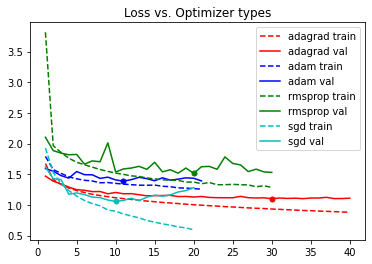

In [0]:
optimizers = ['adagrad','adam','rmsprop','sgd']
tuningOptimizer(500,0.01,optimizers)

## Tuning hyperparameter on validation set
using SGD and ReLU from the previous experiment results

In [0]:
net = ConvNet()
# Define a Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
cnn_best_acc_valid = 0
epochs_no_improve = 0
cnn_min_loss = np.Inf
cnn_local_best = np.Inf
def tuningParam(maxepoch,lrs,dropouts):
  '''
  lrs: a list containing all lrs we want to test on
  '''
  colors = ['lightcoral', 'maroon', 'red', 'darkgoldenrod', 'darkorange', 'gold','cadetblue','lightskyblue','steelblue']
  plt.figure(figsize=(12,10))
  global net     
  global optimizer
  global cnn_min_loss
  global cnn_min_loss
  global epochs_no_improve
  global cnn_local_best
  i=0 # counter for the color
  for lr in lrs:
    for drop,color in zip(dropouts,colors):
      cnn_min_loss = np.Inf
      epochs_no_improve = 0
      cnn_local_best = 0 # reset the single model's acc to 0 at the start
      best_epoch = 0

      net = ConvNet(dropout=drop,activation = 'ReLU')
      optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
      net = net.to(device)
      if  device== 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
      criterion = nn.CrossEntropyLoss()
      epoch_list = list(range(1,maxepoch+1))
      valid_acc_list = []
      train_acc_list = [] 
      train_loss_list = []
      valid_loss_list = []
      start = time.time()
      for epoch in epoch_list:  # train and validate the model until
        train_acc, train_loss = train(epoch)
        valid_acc, valid_loss, best_epoch, stop = validate(epoch,lr=lr,best_epoch=best_epoch,dropout=drop,activation='ReLU')
        valid_acc_list.append(valid_acc)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        if stop: # if reach the patience limit, exit the loop
          break

      # plot results
      end = time.time()
      print('Time spent: %0.2f s' % (end-start))

      plt.plot(epoch_list[:len(train_loss_list)], train_loss_list, '--', color=colors[i], label='lr='+str(lr)+'drop='+str(drop)+"--train")
      plt.plot(epoch_list[:len(valid_loss_list)], valid_loss_list, color=colors[i], label='lr='+str(lr)+'drop='+str(drop)+"--val")
      #best_model = torch.load('bestCNN_valid.pth')
      plt.plot(best_epoch, min(valid_loss_list), marker='o', color=colors[i],  markersize=5)
      print('Learning rate: {}- Dropout: {} - lowest loss: {}'.format(lr, drop, min(valid_loss_list)))
      print('-'*100)
      i +=1
  plt.legend(bbox_to_anchor=(1.04,0.5),loc='center left')
  plt.title("Loss vs. Hyperparameters")
  plt.savefig("cnn_params.png")



Epoch: 1
Training accuracy : 26.585 %
Validation accuracy : 36.630 %
Saving..

Epoch: 2
Training accuracy : 35.237 %
Validation accuracy : 37.740 %
Saving..

Epoch: 3
Training accuracy : 39.292 %
Validation accuracy : 38.090 %
Saving..

Epoch: 4
Training accuracy : 41.695 %
Validation accuracy : 41.710 %
Saving..

Epoch: 5
Training accuracy : 43.938 %
Validation accuracy : 45.490 %
Saving..

Epoch: 6
Training accuracy : 45.163 %
Validation accuracy : 45.670 %
Saving..

Epoch: 7
Training accuracy : 45.455 %
Validation accuracy : 44.490 %

Epoch: 8
Training accuracy : 46.858 %
Validation accuracy : 45.250 %

Epoch: 9
Training accuracy : 47.038 %
Validation accuracy : 48.250 %
Saving..

Epoch: 10
Training accuracy : 47.595 %
Validation accuracy : 43.930 %

Epoch: 11
Training accuracy : 47.398 %
Validation accuracy : 47.360 %

Epoch: 12
Training accuracy : 47.752 %
Validation accuracy : 44.950 %

Epoch: 13
Training accuracy : 48.530 %
Validation accuracy : 49.590 %
Saving..

Epoch: 14
Tra

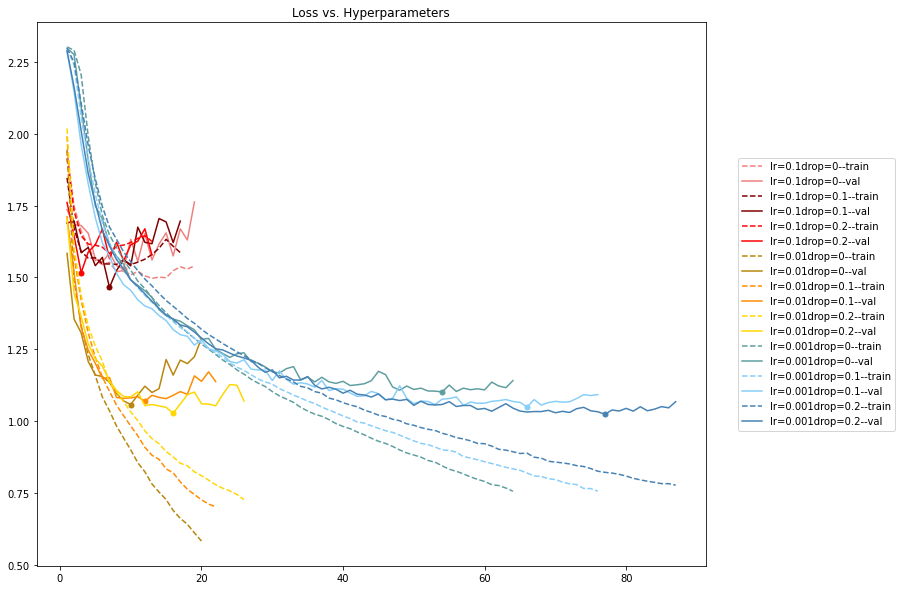

In [0]:
lrs = [0.1,0.01,0.001]
dropouts = [0,0.1,0.2]
tuningParam(500,lrs,dropouts)
# best is 0.01, 0.2

# Testing

## Final CNN model

In [0]:
transform_train = transforms.Compose([                                      
    # image transformations chained by Compose
    transforms.ToTensor(),
    # changed to the computed mean/std 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

transform_test = transforms.Compose([                                      
    # image transformations chained by Compose
    transforms.ToTensor(),
    # changed to the computed mean/std 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# DataLoader represents a Python iterable over a dataset, with support for automate batching etc.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False,
                                           num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import numpy as np
cnn_min_loss = np.Inf
epochs_no_improve = 0  # a counter for the times that the epoch doesn't reduce the min loss
def test(epoch,lr,best_epoch,dropout=0,patience=20,stop=False):
  '''Evaluate the model, return the test acc and loss'''
  global cnn_best_acc   #refer to a global variable
  global cnn_min_loss, epochs_no_improve
  net.eval()    # switch to evaluation mode
  test_loss = 0
  batch_idx = 0
  correct = 0
  total = 0
  with torch.no_grad():   # with no_grad() we have higher speeds and can use larger batch size 
      for batch_idx, (inputs, targets) in enumerate(testloader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

  print('Test accuracy : %0.3f %%' % (100 * correct / total))


  # Save the model with the largest test acc
  acc = 100.*correct/total
  if acc > cnn_best_acc:
      print('Saving..')
      state = {
          'net': net.state_dict(),
          'acc': acc,
          'epoch': epoch,
          'lr': lr,
          'dropout': dropout,
      }
      torch.save(state, 'bestCNN.pth')
      cnn_best_acc = acc
  # Early stopping based on the loss 
  # if the test loss is decreasing in 'patience' consecutive times, return the signal to break
  if test_loss < cnn_min_loss:
    epochs_no_improve = 0
    cnn_min_loss = test_loss
    best_epoch = epoch
  else:
    epochs_no_improve += 1
  if epochs_no_improve == patience:
    print('Early stopping!')
    stop = True

  return 100 * correct / total, test_loss/(batch_idx+1), best_epoch, stop #return the test acc for current model

In [0]:


# function to plot the acc vs epoch num
# cnn_best_acc = 0
def acc_epoch_plot(max_epoch,lr,dropout):
    # cnn_best_acc = 0
    global cnn_min_loss
    global epochs_no_improve
    cnn_min_loss = np.Inf
    epochs_no_improve = 0
    cnn_local_best = 0 # reset the single model's acc to 0 at the start
    epoch_list = list(range(1,max_epoch+1))
    test_acc_list = []
    train_acc_list = [] 
    train_loss_list = []
    test_loss_list = []
    best_epoch = 0 
    start = time.time()
    for epoch in epoch_list:  # train and validate the model until
      train_acc, train_loss = train(epoch)
      test_acc, test_loss, best_epoch, stop = test(epoch,lr=lr,best_epoch=best_epoch,dropout=dropout)
      test_acc_list.append(test_acc)
      train_acc_list.append(train_acc)
      train_loss_list.append(train_loss)
      test_loss_list.append(test_loss)
      if stop: # if reach the patience limit, exit the loop
        break
    end = time.time()
    print('Time spent: %0.2f s' % (end-start))
    print('Learning rate: {}- Dropout: {} - lowest loss: {}'.format(lr, dropout, min(test_loss_list)))
    plt.figure(figsize=(12,10))

    plt.subplot(211)
    plt.plot(epoch_list[:len(train_acc_list)],train_acc_list,label='train')
    plt.plot(epoch_list[:len(test_acc_list)],test_acc_list,label='test')
    #plt.plot(best_epoch, max(valid_loss_list), marker='o',  markersize=5)
    plt.legend()
    plt.title("Train & Test Accuracy vs. # of Epochs" )
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")

    plt.subplot(212)
    plt.plot(epoch_list[:len(train_loss_list)], train_loss_list,label='train')
    plt.plot(epoch_list[:len(test_loss_list)], test_loss_list,label='test')
    plt.plot(best_epoch, min(test_loss_list), marker='o',  markersize=5)
    plt.legend()
    plt.title("Train & Test loss vs. # of Epochs" )
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.savefig('train-val-acc-lr='+str(lr)+'drop='+str(dropout)+'.png')
    plt.show()

In [0]:
net = ConvNet()
# Define a Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
cnn_best_acc = 0
def testing(lr,epoch,dropout=0):
  global net 
  global optimizer
  net = ConvNet(dropout=dropout)
  net = net.to(device)
  if  device== 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  acc_epoch_plot(max_epoch=epoch, lr=lr, dropout=dropout)



Epoch: 1
Training accuracy : 12.168 %
Test accuracy : 15.080 %
Saving..

Epoch: 2
Training accuracy : 18.644 %
Test accuracy : 24.180 %
Saving..

Epoch: 3
Training accuracy : 24.992 %
Test accuracy : 28.290 %
Saving..

Epoch: 4
Training accuracy : 28.624 %
Test accuracy : 31.640 %
Saving..

Epoch: 5
Training accuracy : 32.220 %
Test accuracy : 35.850 %
Saving..

Epoch: 6
Training accuracy : 36.052 %
Test accuracy : 39.210 %
Saving..

Epoch: 7
Training accuracy : 38.634 %
Test accuracy : 41.410 %
Saving..

Epoch: 8
Training accuracy : 40.910 %
Test accuracy : 43.180 %
Saving..

Epoch: 9
Training accuracy : 42.608 %
Test accuracy : 45.130 %
Saving..

Epoch: 10
Training accuracy : 44.078 %
Test accuracy : 46.510 %
Saving..

Epoch: 11
Training accuracy : 46.032 %
Test accuracy : 47.660 %
Saving..

Epoch: 12
Training accuracy : 47.088 %
Test accuracy : 49.350 %
Saving..

Epoch: 13
Training accuracy : 48.436 %
Test accuracy : 50.570 %
Saving..

Epoch: 14
Training accuracy : 49.548 %
Test ac

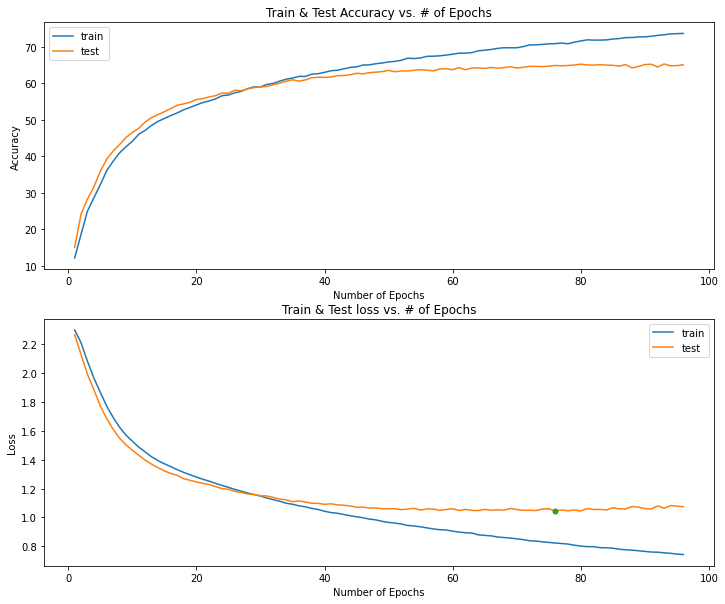

In [0]:
testing(lr=0.001,epoch=250,dropout=0.2)

In [0]:
# print the best model by test acc
PATH = 'bestCNN.pth'
model = torch.load(PATH)
print('Test accuracy of the best CNN model with data augmentation is : %0.3f %% ' % (model['acc']))
print('Hyperparameters of the best CNN model are: Epoch = %d  learning rate = %f  dropout = %f' % (model['epoch'],model['lr'],model['dropout']))

Test accuracy of the best CNN model with data augmentation is : 65.260 % 
Hyperparameters of the best CNN model are: Epoch = 93  learning rate = 0.001000  dropout = 0.200000


## Experiment on Data augmentation

In [0]:
transform_train = transforms.Compose([                                      
    # image transformations chained by Compose
    # using data augmentation to make the model more robust
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # changed to the computed mean/std 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

transform_test = transforms.Compose([                                      
    # image transformations chained by Compose
    transforms.ToTensor(),
    # changed to the computed mean/std 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# DataLoader represents a Python iterable over a dataset, with support for automate batching etc.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False,
                                           num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified



Epoch: 1
Training accuracy : 10.186 %
Test accuracy : 10.640 %
Saving..

Epoch: 2
Training accuracy : 14.902 %
Test accuracy : 21.200 %
Saving..

Epoch: 3
Training accuracy : 23.450 %
Test accuracy : 28.320 %
Saving..

Epoch: 4
Training accuracy : 28.018 %
Test accuracy : 32.770 %
Saving..

Epoch: 5
Training accuracy : 30.942 %
Test accuracy : 35.870 %
Saving..

Epoch: 6
Training accuracy : 33.088 %
Test accuracy : 37.490 %
Saving..

Epoch: 7
Training accuracy : 34.792 %
Test accuracy : 39.170 %
Saving..

Epoch: 8
Training accuracy : 35.806 %
Test accuracy : 40.300 %
Saving..

Epoch: 9
Training accuracy : 37.140 %
Test accuracy : 41.270 %
Saving..

Epoch: 10
Training accuracy : 38.356 %
Test accuracy : 42.840 %
Saving..

Epoch: 11
Training accuracy : 39.580 %
Test accuracy : 43.880 %
Saving..

Epoch: 12
Training accuracy : 40.242 %
Test accuracy : 45.280 %
Saving..

Epoch: 13
Training accuracy : 41.476 %
Test accuracy : 46.040 %
Saving..

Epoch: 14
Training accuracy : 42.404 %
Test ac

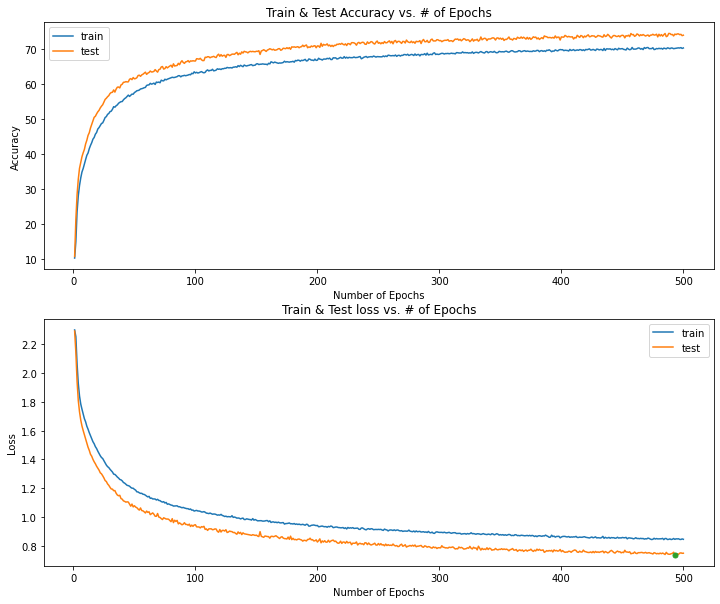

In [0]:
testing(lr=0.001,epoch=500,dropout=0.2,patience=20)

In [0]:
# print the best model by test acc
PATH = 'bestCNN.pth'
model = torch.load(PATH)
print('Test accuracy of the best CNN model with data augmentation is : %0.3f %% ' % (model['acc']))
print('Hyperparameters of the best CNN model are: Epoch = %d  learning rate = %f  dropout = %f' % (model['epoch'],model['lr'],model['dropout']))

Test accuracy of the best CNN model with data augmentation is : 74.450 % 
Hyperparameters of the best CNN model are: Epoch = 488  learning rate = 0.001000  dropout = 0.200000


# Evaluation

## load net

In [0]:
cnn = ConvNet()
state=torch.load('bestCNN.pth')['net']
cnn.load_state_dict(state)

<All keys matched successfully>

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 85 %
Accuracy of  bird : 69 %
Accuracy of   cat : 47 %
Accuracy of  deer : 66 %
Accuracy of   dog : 60 %
Accuracy of  frog : 69 %
Accuracy of horse : 80 %
Accuracy of  ship : 84 %
Accuracy of truck : 82 %


## Classification Report and Confusion matrix

In [0]:
def convert_image (image):
  return image.reshape((image.shape[0],-1))

In [0]:
# Reshape image input
# For each image with shape (32,32,3), reshape it to a single row of length 32*32*3
trainset_array = next(iter(torch.utils.data.DataLoader(trainset,batch_size=len(trainset))))[0].numpy()
testset_array = next(iter(torch.utils.data.DataLoader(testset,batch_size=len(testset))))[0].numpy()
train_X_array,test_X_array = convert_image(trainset_array), convert_image(testset_array)


In [0]:
# Add a column of 1's as the bias term
train_X_design = np.concatenate((np.ones((train_X_array.shape[0],1)), train_X_array), axis=1)
test_X_design = np.concatenate((np.ones((test_X_array.shape[0],1)), test_X_array), axis=1)
#train_X_design.shape

In [0]:
train_y_array = np.asarray(trainset.targets)
test_y_array = np.asarray(testset.targets)
#train_y_array.shape

In [0]:
from torch.autograd import Variable
def cnn_predict():
  y_score=[]  # predicted values for each instance
  y=[]
  y_predicted = []
  for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = cnn(Variable(images.to(device)))
      _, predicted = torch.max(outputs.data, 1)
      c = (predicted == labels.to(device)).squeeze().cpu().numpy()
      y_score.append(outputs.data.cpu().detach().numpy())
      y_predicted.append(predicted.cpu())
      y.append(labels.cpu().numpy())
  # concatenate every mini-batch result as an nparray
  y = np.concatenate(y)
  y_score = np.concatenate(y_score)
  y_predicted = np.concatenate(y_predicted)
  # one-hot encode the label y
  N = y.shape[0]
  C = 10
  y_hot = np.zeros((N,C))
  y_hot[np.arange(N), y] = 1
  # return y_predicted without one-hot encoding, y_label with one hot encoding, y_score which is the raw output in (10000,10)
  return y_predicted, y_hot, y_score


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
import seaborn as sn

def plot_report(model, y_test, predictions):
    # classification report
    print(classification_report(y_true = y_test, y_pred = predictions, target_names = classes))
    # confusion matrix
    cm = confusion_matrix(y_true = y_test, y_pred = predictions, normalize = 'true')
    plt.figure(figsize=(10,8))
    sn.heatmap(cm)
    plt.title(model)
    plt.savefig(str(model)[0:7]+'_cm.jpg')
    plt.show()

def evaluation(X_test, y_test):
    print("--------------------------------------------------------------------------------------")
    print("CNN with learning rate = 0.001  dropout = 0.20")
    cnnPredict,_,_ = cnn_predict()
    plot_report(cnn, y_test, cnnPredict)

--------------------------------------------------------------------------------------
CNN with learning rate = 0.001  dropout = 0.20
              precision    recall  f1-score   support

       plane       0.77      0.79      0.78      1000
         car       0.85      0.87      0.86      1000
        bird       0.69      0.62      0.66      1000
         cat       0.53      0.58      0.55      1000
        deer       0.76      0.67      0.71      1000
         dog       0.62      0.65      0.64      1000
        frog       0.80      0.82      0.81      1000
       horse       0.75      0.80      0.78      1000
        ship       0.87      0.81      0.84      1000
       truck       0.83      0.81      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.75     10000
weighted avg       0.75      0.74      0.75     10000



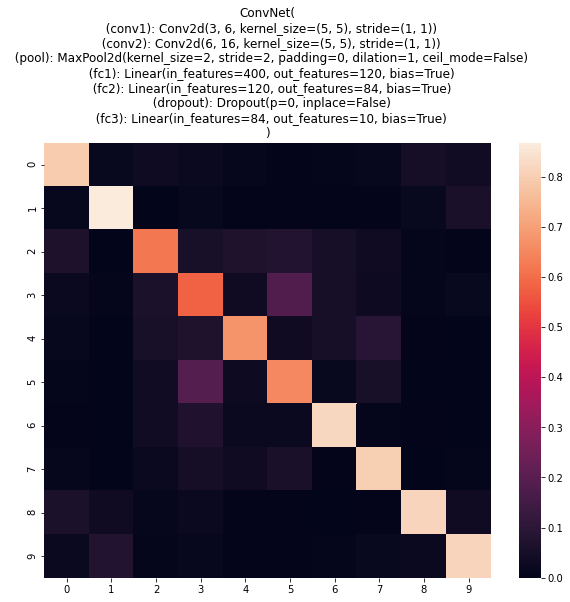

In [0]:
evaluation(test_X_design, test_y_array)

## ROC

In [0]:
from torch.autograd import Variable
y_score=[]
y=[]
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.to(device)))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.to(device)).squeeze().cpu().numpy()
    y_score.append(outputs.cpu().detach().numpy())
    y.append(labels.cpu().numpy())

In [0]:
y = np.concatenate(y)
y_score = np.concatenate(y_score)

In [0]:
N = y.shape[0]
C = 10
y_hot = np.zeros((N,C))
y_hot[np.arange(N), y] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/usr/

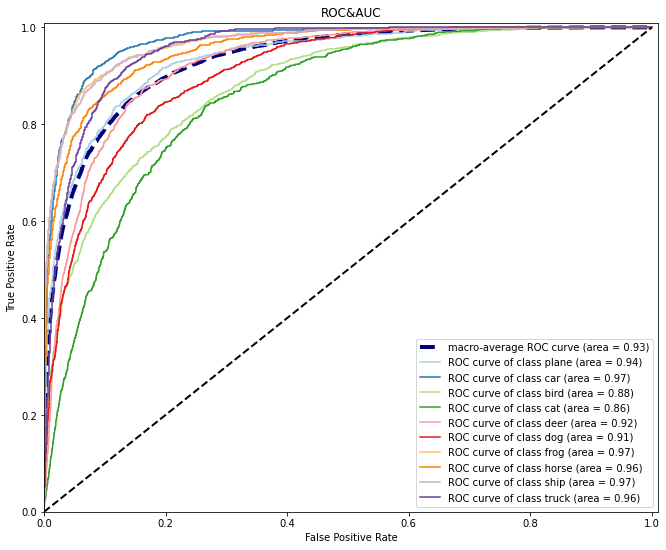

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
import seaborn as sns

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Compute macro-average ROC curve and ROC area
#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= 10

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot of a ROC curve for a specific class
plt.figure(figsize=(11, 9))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle='--', linewidth=4)
colors = sns.color_palette("Paired")
for i, color, j in zip(range(10), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(j, roc_auc[i]),linewidth=1.5)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC&AUC')
plt.legend(loc="lower right")
plt.show()
